# Introduction
Aside from transfer phenomena, temperature can also impact host metabolism. Here we construct models to evaluate the effect of temperature on metabolism, based on overall reaction stoichiometry and corresponding thermodynamics. 

In [8]:
from os.path import dirname, join, pardir
from cobra.io import read_sbml_model
from dfba import DfbaModel, ExchangeFlux, KineticVariable
from dfba.plot.matplotlib import *
import numpy as np
import math

from IPython.display import Image
from IPython.core.display import HTML

ModuleNotFoundError: No module named 'dfba'

**Define Parameters**

In [7]:
data_dir = "/../"

In [3]:
R = 8.314 # [m^3*Pa/K/mol]

#Temperature range:
T0 = 273.15
T = np.arange(T0, T0+80+1, 1)

def Kelvin_Celsius(t):
    """
    This function converts Temperature values from Kelvin to degrees Celsius
    """
    return t-273.15

def Celsius_Kelvin(t):
    """
    This function converts Temperature values from degrees Celsius to Kelvin
    """
    return t+273.15

# Biological Parameters Acetogen

**Energy Requirements for Growth and Overall Stoichiometry**
\[REF] Heijnen J.J. (2010) Impact of Thermodynamic Principles in Systems Biology. In: Wittmann C., Krull R. (eds) Biosystems Engineering II. Advances in Biochemical Engineering / Biotechnology, vol 121. Springer, Berlin, Heidelberg. https://doi.org/10.1007/10_2009_63

The energy requirement for autotrophic growth of 1 C-mol cell mass, $a_{G}$ , is set to 1000 kJ/C-mol. 

In [9]:
a_G = 1000 #kJ/CmolX
print("a_G =", a_G, "[kJ/CmolX]")

a_G = 1000 [kJ/CmolX]


**Energy Requirements for Maintenance**

\[REF]: L. Tijhuis, M.C. M. van Loosdrecht, and J. J. Heijnen, A Thermodynamically Based Correlation for Maintenance Gibbs Energy Requirements in Aerobic and Anaerobic Chemotrophic Growth 

The maintenance energy requirement ($m_{g}$) is used to determine the amount of substrate used to provide energy for maintenance. This has been shown to be predominantly dependent on process temperature and less so on carbon source and strain. An approximation for ($m_{g}$) was used from Tijhuis et al. in a method similar to that of Redl et al., 2017.

m_G(300) = 1.25 [kJ/h/CmolX]


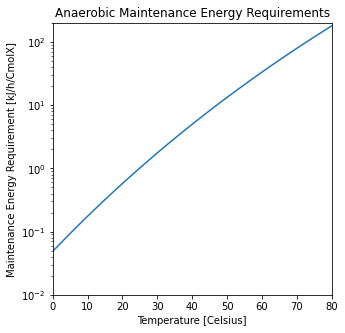

In [5]:
def m_G(T):
    return 3.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]

print("m_G(300) =", round(m_G(300),2), "[kJ/h/CmolX]")

plt.figure(figsize=(5,5))
plt.title(f"Anaerobic Maintenance Energy Requirements")
plt.axis([0, 80, 0.01, 200])
plt.xlabel('Temperature [Celsius]')
plt.ylabel('Maintenance Energy Requirement [kJ/h/CmolX]')
plt.yscale('log')
plt.plot(Kelvin_Celsius(T), m_G(T))

**Calculate Gibbs Free Energy and Enthalpy**
Next the gibbs free energy and enthalpy of the reactions are calculated and the effect of temperature on them determined by using Hess's law.

<p>Given the catabolic reaction stoichiometries of acetogenesis:</p>
Homoacetogenic:
<p>$ -2 CO_2 - 4 H_2 + CH_3COOH + 2 H_2O $</p>

Carboxydotrophic:
<p>$ -4 CO - 2 H_2O + CH_3COOH + 2 CO_2 $</p>

As well as the reaction stoichiometry for methanogenesis:
<p>$ -1 CO_2 - 2 H_2 + CH_4 + 2 H_2O $</p>

Gibbs energy:
  DrG0_carb = -155.7 [kJ/mol]
  DrG0_hom = -75.3 [kJ/mol]

Enthalpy:
  DrH0_carb = -258.7 [kJ/mol]
  DrH0_hom = -266.3 [kJ/mol]

Temperature corrected Gibbs energy:
  DrGT_carb = -155.1 [kJ/mol]
  DrGT_hom = -74.1 [kJ/mol]


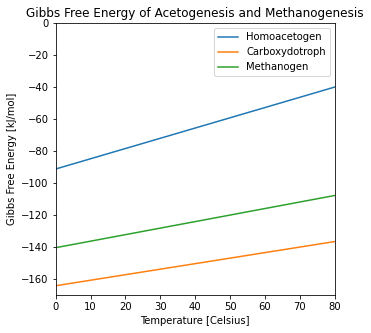

In [6]:
#Gibbs energy of Formation at 298.15
DfG0_actn = -159.7 #[kJ/mol]
DfG0_actt = -389.9 #[kJ/mol]
DfG0_co2 = -394.4 #[kJ/mol]
DfG0_co = -137.2 #[kJ/mol]
DfG0_h2o = -237.1 #[kJ/mol]
DfG0_h2 = 0 #[kJ/mol]
DfG0_ch4 = -50.53 #[kJ/mol]

#standard molar enthalpy
DfH0_actn = -249.4 #[KJ/mol]
DfH0_actt = -483.5 #[KJ/mol]
DfH0_co2 = -394.4 #[KJ/mol]
DfH0_co = -110.5 #[KJ/mol]
DfH0_h2o = -285.8 #[KJ/mol]
DfH0_h2 = 0 #[KJ/mol]
DfH0_ch4 = -74.8 #[KJ/mol]

#Hess's law:
DrG0_carb = -4*DfG0_co - 2*DfG0_h2o + DfG0_actt + 2*DfG0_co2
DrG0_hom = -4*DfG0_h2 - 2*DfG0_co2 + DfG0_actt + 2*DfG0_h2o
DrG0_met = -1*DfG0_co2 - 4*DfG0_h2 + DfG0_ch4 + 2*DfG0_h2o

print("Gibbs energy:\n",
      " DrG0_carb =",round(DrG0_carb,1),"[kJ/mol]\n",
      " DrG0_hom =",round(DrG0_hom,1),"[kJ/mol]\n")

DrH0_carb = -4*DfH0_co - 2*DfH0_h2o + DfH0_actt + 2*DfH0_co2
DrH0_hom = -4*DfH0_h2 - 2*DfH0_co2 + DfH0_actt + 2*DfH0_h2o
DrH0_met = -1*DfH0_co2 - 4*DfH0_h2 + DfH0_ch4 + 2*DfH0_h2o

print("Enthalpy:\n",
      " DrH0_carb =", round(DrH0_carb,1),"[kJ/mol]\n",
      " DrH0_hom =", round(DrH0_hom,1),"[kJ/mol]\n")

#Gibbs–Helmholtz equation for temperature correction
def DrGT_carb(T):
    return DrG0_carb * (T/298.15) + DrH0_carb * (1-T/298.15)
def DrGT_hom(T):
    return DrG0_hom * (T/298.15) + DrH0_hom * (1-T/298.15)
def DrGT_met(T):
    return DrG0_met * (T/298.15) + DrH0_met * (1-T/298.15)

print("Temperature corrected Gibbs energy:\n",
      " DrGT_carb =",round(DrGT_carb(300),1),"[kJ/mol]\n",
      " DrGT_hom =",round(DrGT_hom(300),1),"[kJ/mol]")

#dropped concentration correction, in accordance with book

plt.figure(figsize=(5,5))
plt.title(f"Gibbs Free Energy of Acetogenesis and Methanogenesis")
plt.axis([0, 80, -170, 0])
plt.xlabel('Temperature [Celsius]')
plt.ylabel('Gibbs Free Energy [kJ/mol]')
plt.plot(Kelvin_Celsius(T), DrGT_hom(T))
plt.plot(Kelvin_Celsius(T), DrGT_carb(T))
plt.plot(Kelvin_Celsius(T), DrGT_met(T))
plt.legend(['Homoacetogen','Carboxydotroph','Methanogen'])


The calculated gibbs free energies of reaction can be corrected for the process temperature with the Gibbs-Helmholtz equation. Together with the maintenance requirement, the yield of product (acetate or methane) and biomass on substrate can be calculated, across a range of temperatures.

This is done by balancing the catabolic and anabolic reactions shown below, in terms of gibbs free energy, whilst accounting for maintanance and the energy needed for growth. 

Moving forward, we focus solely on acetogenesis.

<p>Given the reaction stoichiometries: (top is catabolic, bottom is anabolic, per type)</p>

<p>Homoacetogenic</p>
<p>$ -2 CO_2 - 4 H_2 + CH_3COOH + 2 H_2O = 0$</p>
<p>$ -CO_2 - 2.1 H_2 - 0.2 NH_3 + CH_{1.8}O_{0.5}N_{0.2} + 1.5 H_2O = 0$ </p>
<p>Carboxydotrophic</p>
<p>$ -4 CO - 2 H_2O + CH_3COOH + 2 CO_2 = 0$</p>
<p>$ -2.1 CO - 0.6 H_2O - 0.2 NH_3 + CH_{1.8}O_{0.5}N_{0.2} + 1.1 CO_2 = 0$</p>



Y_PS carb at 37°C : 0.198
Y_PS carb at 60°C : 0.2
Y_PS hom at 37°C : 0.224
Y_PS hom at 60°C : 0.229
increase of Y_PS carb at 37-60°C:  1.011
increase of Y_PS hom at 37-60°C:  1.024


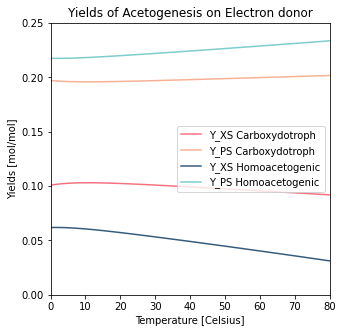

In [28]:
µ = 0.3 #[/h]
a_G = 1000 #kJ/CmolX

def R_X(T):
    return 1 + T*0

def R_CO_carb(T):
    m_G = 0.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]
    DrGT_carb = DrG0_carb * (T/298.15) + DrH0_carb * (1-T/298.15)
    return -4 * (-(m_G+a_G*µ)/DrGT_carb) -2.1

def R_actt_carb(T):
    m_G = 0.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]
    DrGT_carb = DrG0_carb * (T/298.15) + DrH0_carb * (1-T/298.15)
    return -(m_G+a_G*µ)/DrGT_carb

def R_H2_hom(T):
    m_G = 0.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]
    DrGT_hom = DrG0_hom * (T/298.15) + DrH0_hom * (1-T/298.15)
    return -4 * (-(m_G+a_G*µ)/DrGT_hom) -2.1

def R_actt_hom(T):
    m_G = 0.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]
    DrGT_hom = DrG0_hom * (T/298.15) + DrH0_hom * (1-T/298.15)
    return -(m_G+a_G*µ)/DrGT_hom

plt.figure(figsize=(5,5))
plt.title(f"Yields of Acetogenesis on Electron donor")
plt.axis([0, 80, 0, 0.25])
plt.xlabel('Temperature [Celsius]')
plt.ylabel('Yields [mol/mol]')
plt.plot(Kelvin_Celsius(T), -R_X(T)/R_CO_carb(T), color='#F67280')
plt.plot(Kelvin_Celsius(T), -R_actt_carb(T)/R_CO_carb(T), color='#F8B195')
plt.plot(Kelvin_Celsius(T), -R_X(T)/R_H2_hom(T), color='#355C7D')
plt.plot(Kelvin_Celsius(T), -R_actt_hom(T)/R_H2_hom(T), color='#7ECCCC')
#plt.legend(['Y_PS Carboxydotroph','Y_PS Homoacetogenic'])
plt.legend(['Y_XS Carboxydotroph','Y_PS Carboxydotroph','Y_XS Homoacetogenic','Y_PS Homoacetogenic'])

print("Y_PS carb at 37°C :", round(-R_actt_carb(Celsius_Kelvin(37))/R_CO_carb(Celsius_Kelvin(37)),3))
print("Y_PS carb at 60°C :", round(-R_actt_carb(Celsius_Kelvin(60))/R_CO_carb(Celsius_Kelvin(60)),3))
print("Y_PS hom at 37°C :", round(-R_actt_hom(Celsius_Kelvin(37))/R_H2_hom(Celsius_Kelvin(37)),3))
print("Y_PS hom at 60°C :", round(-R_actt_hom(Celsius_Kelvin(60))/R_H2_hom(Celsius_Kelvin(60)),3))

print("increase of Y_PS carb at 37-60°C: ", 
      round((-R_actt_carb(Celsius_Kelvin(60))/R_CO_carb(Celsius_Kelvin(60)))/
             (-R_actt_carb(Celsius_Kelvin(37))/R_CO_carb(Celsius_Kelvin(37))),3))
print("increase of Y_PS hom at 37-60°C: ", 
      round((-R_actt_hom(Celsius_Kelvin(60))/R_H2_hom(Celsius_Kelvin(60)))/
             (-R_actt_hom(Celsius_Kelvin(37))/R_H2_hom(Celsius_Kelvin(37))),3))

From the calculated yields, the product to biomass ratio of the arboxydotrophic and homoacetogenic reactions can be estimated, for a range of temperatures.

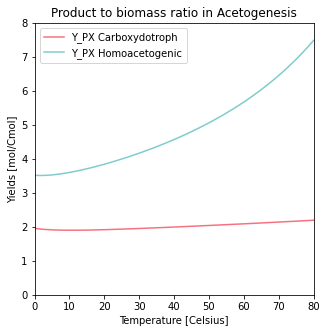

In [10]:
µ = 0.3 #[/h]
a_G = 1000 #kJ/CmolX

plt.figure(figsize=(5,5))
plt.title(f"Product to biomass ratio in Acetogenesis")
plt.axis([0, 80, 0, 8])
plt.xlabel('Temperature [Celsius]')
plt.ylabel('Yields [mol/Cmol]')
plt.plot(Kelvin_Celsius(T), R_actt_carb(T)/R_X(T), color='#F67280')
plt.plot(Kelvin_Celsius(T), R_actt_hom(T)/R_X(T), color='#7ECCCC')

plt.legend(['Y_PX Carboxydotroph','Y_PX Homoacetogenic'])

In [10]:
#calculate increase in Ypx for the homoacetogen, between 37 to 60 degrees C.
print(round(R_actt_hom(Celsius_Kelvin(37))/R_X(Celsius_Kelvin(37)),2))
print(round(R_actt_hom(Celsius_Kelvin(60))/R_X(Celsius_Kelvin(60)),2))

print("increase 37-60°C: ", round((R_actt_hom(Celsius_Kelvin(60))/R_X(Celsius_Kelvin(60)))/(R_actt_hom(Celsius_Kelvin(37))/R_X(Celsius_Kelvin(37))),2))

NameError: name 'R_actt_hom' is not defined

**?? What is the next plot??**
Generally YXP isn't really a parameter used at all, and as we don't use it in the paper either maybe we should remove this plot? Or what do we get out of it/use this for?

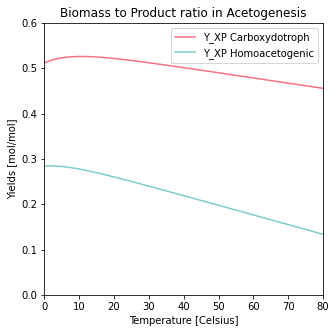

In [12]:
µ = 0.3 #[/h]
a_G = 1000 #kJ/CmolX

plt.figure(figsize=(5,5))
plt.title(f"Biomass to Product ratio in Acetogenesis")
plt.axis([0, 80, 0, 0.6])
plt.xlabel('Temperature [Celsius]')
plt.ylabel('Yields [mol/mol]')
plt.plot(Kelvin_Celsius(T), R_X(T)/R_actt_carb(T), color='#F67280')
plt.plot(Kelvin_Celsius(T), R_X(T)/R_actt_hom(T), color='#7ECCCC')

plt.legend(['Y_XP Carboxydotroph','Y_XP Homoacetogenic'])